# Clustering

In this notebook, we aim at creating a representation of all financial assets in the database that allows to group them according to some shared characteristics. This also includes dealing with categorical and null values as well as defining a preprocessing function.


### Import statements

In [1]:
# Import statements 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### 1° Loading the dataset

In [2]:
filepath = '../../RFQ_Data_Challenge_HEC.csv'
df = pd.read_csv(filepath)
df.head()

C:\Users\gascm\AppData\Local\Temp\ipykernel_20972\1895652701.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity
0,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Bnp Reunion,0.0,NATIXIS SELL,77551,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
1,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,8163,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
2,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Qbe,0.0,NATIXIS SELL,20408,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
3,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,16327,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
4,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Constantin Durie,CON,Scp Laureau-Jeannerot,0.0,NATIXIS SELL,244898,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874


### 2° Defining the preprocessing function

Insights on some features :
- **Deal_Date** : The date on which a financial deal is executed. Needs to be converteted in datetime.
- **ISIN** : International Securities Identification Number, a unique identifier for Financial instruments.
- **company_short_name** : the name of the issuer of the financial instrument. It corresponds to the client name.
- **B_price** : The bid price of the financial instrument. To be converted to int (object for the moment)
- **B_side** : Natixis's position as a buyer or seller of the financial instrument (for the moment 'NATIXIS SELL' or 'NATIXIS BUY'). Contient 8 valeurs nulles.
- **Total_Requested_Volume** : The requested volume for buying or selling the financial instrument. It needs to be converted into a numerical column (object for the moment). Contient 2 valeurs nulles.
- **Total_Traded_Volume_Natixis** : The volume of the financial instrument traded by Natixis. Already good data type.
- **Total_Traded_Volume_Away** : The volume of the financial instrument traded by other banks. Already good data type.
- **Total_Traded_Volume** : The total volume of the financial instrument traded. Already good data type.
- **BloomIndustrySector**, **BloomIndustryGroup**,**BloomIndustrySubGroup**
- **maturity** : The length of time during which interest is paid. Some null values are marked as NaT. We convert this column into Datetime type. Some maturities go back to 1900, it is not possible. We delete those.
- **Rating_Fitch** : The credit rating of the financial instrument from Fitch Ratings.
- **Rating_Moodys** : The credit rating of the financial instrument from Moody's.
- **Rating_SP** : The credit rating of the financial instrument from S&P Global Ratings.
- **Ccy** : The currency in which the financial instrument is denominated.
- **Classification** : The activity sector of the company.
- **Tier** : The seniority level of the financial instrument. Lots of null value, we replace them by UNKOWN (627100 values)
- **AssumedMaturity** : The assumed maturity date of the financial instrument. Also contains a lot of null values, we replace them by maturity values (the null values only).
- **Coupon** : The interest rate of the financial instrument. Already a float.
- **Frequency** : The frequency of interest payments on the financial instrument. Takes values 1M, 3M, 6M, 12M. We delete the 'M' and convert the value into int.
- **Type** : The type of interest rate on the financial instrument (fixed or variable).
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **YTWDate** : Yield to Worst - The yield on the first possible redemption date. 
- **SpreadvsBenchmarkMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidASWSpread** : The spread of the financial instrument versus the swap curve.
- **MidZSpread** : The spread of the financial instrument versus the zero- coupon curve.
- **GSpreadMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidModifiedDuration** : The modified duration of the financial instrument. 
- **MidConvexity** : The convexity of the financial instrument.
- **MidEffectiveDuration** : The effective duration of the financial instrument.
- **MidEffectiveConvexity** : The effective convexity of the financial instrument.

Features that can be deleted at first : 
- **Cusip**, same as **cusip** but with more null values 
- **Maturity**, same as **maturity**

Added columns :
- Year, month, day of deal_date
- Year, month, day of maturity
- days to maturity

In [3]:
# Null values analysis for columns with null values below 15000
below_threshold = df.isnull().sum().sort_values(ascending=False) < 15000
print("Columns with null values below 15000:")
print(below_threshold[below_threshold].index)

# Null values analysis for columns with null values above 15000
above_threshold = df.isnull().sum().sort_values(ascending=False) >= 15000
print("\nColumns with null values above or equal to 15000:")
print(above_threshold[above_threshold].index)


Columns with null values below 15000:
Index(['Sales_Initial', 'Sales_Name', 'MidYTM', 'Coupon', 'Ccy',
       'BloomIndustryGroup', 'BloomIndustrySector', 'Instrument', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Classification', 'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date'],
      dtype='object')

Columns with null values above or equal to 15000:
Index(['Tier', 'AssumedMaturity', 'YTWDate', 'GSpreadMid',
       'SpreadvsBenchmarkMid', 'Cusip', 'MidEffectiveConvexity',
       'MidEffectiveDuration', 'MidASWSpread', 'Rating_Moodys', 'MidConvexity',
       'Rating_Fitch', 'MidZSpread', 'Rating_SP', 'MidModifiedDuration',
       'Country', 'lb_Platform_2'],
      dtype='object')


In [4]:
def preprocess_dataframe(df):
    """
    Preprocesses the input DataFrame with the following steps:
    1. Converts 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' columns to datetime.
    2. Converts 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL').
    3. Converts 'B_Price' and 'Total_Requested_Volume' columns to integers.
    4. Fills null values in 'Tier', 'AssumedMaturity', and 'YTWDate' columns with 'UNKNOWN'.
    5. Converts 'Frequency' feature values into integers (removing 'M' from the end).
    6. Drops the unsused 'Cusip' column.

    Parameters:
    - df (DataFrame): Input DataFrame.

    Returns:
    - DataFrame: Processed DataFrame.
    """

    df = df.copy()

    # Drop null values only for columns below the threshold
    columns_to_delete_null_vales = ['MidYTM', 'Coupon', 'Ccy', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date']
    df = df.dropna(subset=columns_to_delete_null_vales)

    # Convert 'B_Price', 'Total_Requested_Volume', 'Frequency' to integers
    df['Frequency'] = df['Frequency'].str.replace('M', '')
    numerical_columns = ['B_Price', 'Total_Requested_Volume', 'Frequency']
    df.dropna(subset=numerical_columns, inplace=True)
    for column in numerical_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)

    # Fix the error in the B_Price column
    df = df[df['B_Price'] >= 20]

    # Replace NaT with null values in the 'Maturity' column
    df['maturity'].replace({pd.NaT: np.nan}, inplace=True)

    # Convert 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' to datetime
    df['Deal_Date'] = pd.to_datetime(df['Deal_Date'])
    df['maturity'] = pd.to_datetime(df['maturity'], errors='coerce',  format='%Y-%m-%d %H:%M:%S.%f')
    df['AssumedMaturity'] = pd.to_datetime(df['AssumedMaturity'], errors='coerce')
    df['YTWDate'] = pd.to_datetime(df['YTWDate'], errors='coerce')

    # Add year, month, day for clustering 
    df['Year_dealdate'] = df['Deal_Date'].dt.year
    df['Month_dealdate'] = df['Deal_Date'].dt.month
    df['Day_dealdate'] = df['Deal_Date'].dt.day
    df['Year_maturity'] = df['maturity'].dt.year
    df['Month_maturity'] = df['maturity'].dt.month
    df['Day_maturity'] = df['maturity'].dt.day

    # Delete maturities smaller than 2021 (as deal dates starts in 2021)
    df = df[df['maturity'].dt.year >= 2021]

    # Compute number of days between maturity and deal date
    df['Days_to_Maturity'] = (df['maturity'] - df['Deal_Date']).dt.days

    # Replace null values in 'AssumedMaturity' with values from 'Maturity'
    df['AssumedMaturity'] = df['AssumedMaturity'].fillna(df['Maturity'])

    # Convert 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL')
    df = df[df['B_Side'].isin(['NATIXIS SELL', 'NATIXIS BUY'])]
    df['B_Side'] = df['B_Side'].replace({'NATIXIS BUY': 1, 'NATIXIS SELL': 0})

    # Convert null values of 'Tier'
    df['Tier'].fillna('UNKNOWN', inplace=True)

    # Lower string names 
    df['Sales_Name'] = df['Sales_Name'].str.lower()
    df['company_short_name'] = df['company_short_name'].str.lower()

    # Drop unused columns
    columns_to_drop = ['Cusip', 'Maturity']
    df.drop(columns=columns_to_drop, inplace=True)

    return df

In [5]:
df_preprocessed = preprocess_dataframe(df)
pd.set_option('display.max_columns', None)
df_preprocessed.head()

,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,Total_Traded_Volume_Natixis,Total_Traded_Volume_Away,Total_Traded_Volume,BloomIndustrySector,BloomIndustryGroup,BloomIndustrySubGroup,cdcissuerShortName,cdcissuer,Country,lb_Platform_2,maturity,Rating_Fitch,Rating_Moodys,Rating_SP,Ccy,Classification,Tier,AssumedMaturity,Coupon,Frequency,Type,MidPrice,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity,Year_dealdate,Month_dealdate,Day_dealdate,Year_maturity,Month_maturity,Day_maturity,Days_to_Maturity
6,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,heddy kerneves,HED,banque populaire de l'ouest,95,1,13061,0.0,13061.0,13061.0,Government,Sovereign,Sovereign,ROPAYSBAS,NETHERLANDS GOVERNMENT BOND,NETHERLANDS,EMEA,2025-07-15,AAA,Aaa,AAA,EUR,Government,UNKNOWN,2025-07-15,0.25,12,Fixed,95.125999,2.15064,NaT,NaN,-72.215584,-74.569401,NaN,2.60208,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
7,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,license de transport,95,0,136,0.0,136.0,136.0,Government,Sovereign,Sovereign,ROPAYSBAS,NETHERLANDS GOVERNMENT BOND,NETHERLANDS,EMEA,2025-07-15,AAA,Aaa,AAA,EUR,Government,UNKNOWN,2025-07-15,0.25,12,Fixed,95.125999,2.15064,NaT,NaN,-72.215584,-74.569401,NaN,2.60208,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
8,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,ian prechais,IAN,bp val de france,95,0,1224490,0.0,1224490.0,1224490.0,Government,Sovereign,Sovereign,ROPAYSBAS,NETHERLANDS GOVERNMENT BOND,NETHERLANDS,EMEA,2025-07-15,AAA,Aaa,AAA,EUR,Government,UNKNOWN,2025-07-15,0.25,12,Fixed,95.125999,2.15064,NaT,NaN,-72.215584,-74.569401,NaN,2.60208,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
9,2022-11-10,NL0011220108,EK8199722,NETHER 0.25% 15 JUL 2025,elisene arslane,ELI,hsbc,95,0,91837,0.0,91837.0,91837.0,Government,Sovereign,Sovereign,ROPAYSBAS,NETHERLANDS GOVERNMENT BOND,NETHERLANDS,EMEA,2025-07-15,AAA,Aaa,AAA,EUR,Government,UNKNOWN,2025-07-15,0.25,12,Fixed,95.125999,2.15064,NaT,NaN,-72.215584,-74.569401,NaN,2.60208,10.181840,2.47743,8.883440,2022,11,10,2025.0,7.0,15.0,978
12,2023-10-18,IT0005530032,ZM3378175,BTPS 4.45% 01 SEP 2043,ian prechais,IAN,societe generale mer,92,0,2041,0.0,2041.0,2041.0,Government,Sovereign,Sovereign,REPITALIE,BTP,ITALY,EMEA,2043-09-01,BBB,Baa3,BBB,EUR,Government,UNKNOWN,2043-09-01,4.45,6,Fixed,90.022003,5.26552,NaT,213.429138,173.721893,183.643234,217.34491,12.58312,212.362656,11.40296,192.445251,2023,10,18,2043.0,9.0,1.0,7258


In [6]:
df_preprocessed.shape

(314718, 49)

In [7]:
# Function for imputing numerical missing values in the financial columns
def complete_nan_values(df):

    df_unique_isin = df.groupby('ISIN').first()
    columns = ['Classification', 'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
               'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity', 'Year_dealdate', 'Month_dealdate']
    df_by_classification = df_unique_isin[columns].copy()
    df_by_classification = df_by_classification.groupby(['Classification', 'Year_dealdate']).mean().reset_index()

    df_group_by_industry = df_by_classification.groupby('Classification').mean().reset_index()
    numeric_columns = ['SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid', 
                       'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration', 'MidEffectiveConvexity']
    
    df_by_classification['additional_column'] = df_by_classification['Classification'].astype(str) + ' - ' + df_by_classification['Year_dealdate'].astype(str)
    df['additional_column'] = df['Classification'].astype(str) + ' - ' + df['Year_dealdate'].astype(str)

    for column in numeric_columns:
        df_by_classification[column] = df_by_classification[column].fillna(df_by_classification['Classification'].map(df_group_by_industry.set_index('Classification')[column]))

    for column in numeric_columns:
        df[column] = df[column].fillna(df['additional_column'].map(df_by_classification.set_index('additional_column')[column]))

    df.drop(columns=['additional_column'], inplace=True)
    
    return df

In [8]:
df_filled = complete_nan_values(df_preprocessed)
missing_values = df_filled.isnull().sum()
missing_values[missing_values!=0]

Instrument                  788
Sales_Name                  888
Sales_Initial               888
BloomIndustrySector          33
BloomIndustryGroup           33
Country                    7555
lb_Platform_2              7555
Rating_Fitch               4462
Rating_Moodys              3233
Rating_SP                  4473
Classification                2
YTWDate                  308252
MidASWSpread                  5
MidZSpread                    5
GSpreadMid                    5
MidModifiedDuration           5
MidConvexity                  5
MidEffectiveDuration          5
MidEffectiveConvexity         5
dtype: int64

Once we've corrected the B_price error, which sometimes corresponds to yield values (by setting a minimum value of 20), only 314718 lines remain.

### 3° Exploring statistical information on bonds

In [9]:
df_bond = df_preprocessed[df_preprocessed['ISIN']=="IT0003934657"]
df_bond.describe().T

,count,mean,min,25%,50%,75%,max,std
Deal_Date,8333,2023-07-23 22:09:13.846153984,2022-07-25 00:00:00,2023-05-26 00:00:00,2023-08-04 00:00:00,2023-10-19 00:00:00,2023-12-21 00:00:00,NaN
B_Price,8333.0,96.325933,88.0,95.0,96.0,98.0,113.0,2.642183
B_Side,8333.0,0.266891,0.0,0.0,0.0,1.0,1.0,0.442361
Total_Requested_Volume,8333.0,34016.581063,0.0,4082.0,10204.0,40408.0,14285714.0,203875.814006
Total_Traded_Volume_Natixis,8333.0,1915.178687,0.0,0.0,0.0,0.0,14285714.0,157094.230576
Total_Traded_Volume_Away,8333.0,15159.343814,0.0,0.0,0.0,8163.0,6122449.0,107568.620461
Total_Traded_Volume,8333.0,17074.522501,0.0,0.0,0.0,8163.0,14285714.0,190240.723071
maturity,8333,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,NaN
AssumedMaturity,8333,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,2037-02-01 00:00:00,NaN
Coupon,8333.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0


### 4° Defining the preprocessing function for clustering

In [10]:
def preprocess_clustering(df, cols_to_exclude):
    # Drop the columns that we exclude
    df = df.drop(cols_to_exclude, axis=1, errors='ignore')

    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Transform 'Ccy' to 'is_euro' boolean column
    df['is_euro'] = (df['Ccy'] == 'EUR').astype(int)
    # Transform 'Type' to 'is_fixed' boolean column
    df['is_fixed'] = (df['Type'] == 'Fixed').astype(int)
    # Drop the original 'Ccy' and 'Type' columns
    df = df.drop(['Ccy', 'Type'], axis=1, errors='ignore')

    # Ordinal encoding for 'Rating_Fitch'
    rating_mapping = {
        'AAA': 22,
        'AA+': 21,
        'AA': 20,
        'AA-': 19,
        'A+': 18,
        'A': 17,
        'A-': 16,
        'BBB+': 15,
        'BBB': 14,
        'BBB-': 13,
        'BB+': 12,
        'BB': 11,
        'BB-': 10,
        'B+': 9,
        'B': 8,
        'B-': 7,
        'CCC+': 6,
        'CCC': 5,
        'CCC-': 4,
        'CC': 3,
        'C': 2,
        'WD': 1,
        'D': 0,
        'NR': np.nan
    }

    rating_mapping_moodys = {
        'Aaa': 22,
        'Aa1': 21,
        'Aa2': 20,
        '(P)Aa2': 20,
        'Aa3': 19,
        '(P)Aa3': 19,
        'A1': 18,
        '(P)A1': 18,
        'A2': 17,
        '(P)A2': 17,
        'A3': 16,
        '(P)A3': 16,
        'Baa1': 15,
        '(P)Baa1': 15,
        'Baa2': 14,
        '(P)Baa2': 14,
        'Baa3': 13,
        'Ba1': 12,
        'Ba2': 11,
        'Ba3': 10,
        'B1': 9,
        'B2': 8,
        'B3': 7,
        'Caa1': 6,
        'Caa2': 5,
        'Caa3': 4,
        'Ca': 2.5,
        'C': 0
    }

    df['Rating_Fitch_encoded'] = df['Rating_Fitch'].map(rating_mapping)
    df['Rating_SP_encoded'] = df['Rating_SP'].map(rating_mapping)
    df['Rating_Moodys_encoded'] = df['Rating_Moodys'].map(rating_mapping_moodys)
    # Create a unique Rating that averages the 3 Ratings and ignores missing values
    df['Rating'] = df[['Rating_Fitch_encoded', 'Rating_SP_encoded', 'Rating_Moodys_encoded']].mean(axis=1)

    # Map values in 'Country' column
    valid_countries = ['FRANCE', 'ITALY', 'GERMANY', 'NETHERLANDS', 'SPAIN']
    df['Country'] = df['Country'].apply(lambda x: x if x in valid_countries else 'OTHER')
    # Perform one-hot encoding
    df = pd.get_dummies(df, columns=['Country'], prefix='is')

    # Map values in 'Classification' column
    valid_classes = ['Financials', 'Government', 'Industrials', 'Utilities']
    df['Classification'] = df['Classification'].apply(lambda x: x if x in valid_classes else 'OTHER')
    # Perform one-hot encoding
    df = pd.get_dummies(df, columns=['Classification'], prefix='is')

    # Add newly created boolean columns and 'Rating' to agg_dict with average
    agg_dict = {col: 'mean' for col in ['is_euro', 'is_fixed', 'Rating']}
    agg_dict.update({col: 'first' for col in ['is_FRANCE', 'is_ITALY', 'is_GERMANY', 'is_NETHERLANDS', 'is_SPAIN']})
    agg_dict.update({col: 'first' for col in ['is_Financials', 'is_Government', 'is_Industrials', 'is_Utilities']})
    agg_dict.update({num_col: ['min', 'max', 'median'] for num_col in numerical_columns})

    # Grouping by 'ISIN' and aggregating columns
    grouped_df = df.groupby('ISIN').agg(agg_dict).reset_index()

    # Flatten the multi-level column index
    grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]

    # Drop identical columns
    grouped_df = grouped_df.T.drop_duplicates().T

    return grouped_df

In [11]:
cols_to_exclude = ['Deal_Date', 'cusip', 'Instrument', 'Sales_Name', 'Sales_Initial', 'company_short_name', 'Total_Traded_Volume_Natixis',
                   'Total_Traded_Volume_Away', 'cdissuer', 'Tier', 'Year_dealdate', 'Month_dealdate', 'Day_dealdate', 'Days_to_Maturity',
                   'cdissuerShortName', 'lb_Platform_2']
df_clustering = preprocess_clustering(df_filled, cols_to_exclude)

In [12]:
df_clustering.head()

,ISIN_,is_euro_mean,is_fixed_mean,Rating_mean,is_FRANCE_first,is_ITALY_first,is_GERMANY_first,is_NETHERLANDS_first,is_SPAIN_first,is_Financials_first,is_Government_first,is_Industrials_first,is_Utilities_first,B_Price_min,B_Price_max,B_Price_median,B_Side_min,B_Side_max,B_Side_median,Total_Requested_Volume_min,Total_Requested_Volume_max,Total_Requested_Volume_median,Total_Traded_Volume_min,Total_Traded_Volume_max,Total_Traded_Volume_median,Coupon_min,Coupon_max,Coupon_median,Frequency_min,Frequency_max,MidPrice_min,MidPrice_max,MidPrice_median,MidYTM_min,MidYTM_max,MidYTM_median,SpreadvsBenchmarkMid_min,SpreadvsBenchmarkMid_max,SpreadvsBenchmarkMid_median,MidASWSpread_min,MidASWSpread_max,MidASWSpread_median,MidZSpread_min,MidZSpread_max,MidZSpread_median,GSpreadMid_min,GSpreadMid_max,GSpreadMid_median,MidModifiedDuration_min,MidModifiedDuration_max,MidModifiedDuration_median,MidConvexity_min,MidConvexity_max,MidConvexity_median,MidEffectiveDuration_min,MidEffectiveDuration_max,MidEffectiveDuration_median,MidEffectiveConvexity_min,MidEffectiveConvexity_max,MidEffectiveConvexity_median,Year_maturity_min,Month_maturity_min,Day_maturity_min
0,AT0000383864,1.0,1.0,21.0,False,False,False,False,False,False,True,False,False,110,126,112.0,0,1,0.0,0,2122449,14286.0,0.0,2122449.0,9592.0,6.25,6.25,6.25,12,12,110.419762,127.079163,112.316982,0.6494,3.23769,2.94855,14.74143,48.205238,31.070089,-92.459953,-23.11165,-36.86031,-80.192131,-21.09169,-34.07125,7.43871,51.626171,35.860584,3.16226,4.41606,3.498495,13.70098,25.4069,16.758875,3.25192,5.63155,4.03505,11.2101,32.001419,19.12505,2027.0,7.0,15.0
1,AT0000A04967,1.0,1.0,21.0,False,False,False,False,False,False,True,False,False,99,131,111.0,0,1,0.0,0,8163265,9592.0,0.0,8163265.0,4898.0,4.15,4.15,4.15,12,12,103.552841,132.494583,110.889221,1.63245,3.80473,3.166545,50.77877,75.725662,62.114321,-19.249849,30.029989,14.9261,-17.64529,27.424015,13.593732,40.751419,85.924889,64.691807,9.97172,11.42595,10.46476,126.879807,166.019135,140.971497,10.33749,15.32064,11.76933,125.579231,216.827042,155.175697,2037.0,3.0,15.0
2,AT0000A0DXC2,1.0,1.0,21.0,False,False,False,False,False,False,True,False,False,103,113,104.0,0,1,0.0,0,10204082,20408.0,0.0,10204082.0,15102.0,4.85,4.85,4.85,12,12,103.538582,113.266792,104.862549,1.0297,3.3129,2.95505,-3.98206,61.020901,50.342121,-88.60849,-30.5749,-55.127319,-82.060589,-29.441706,-52.924715,-7.01188,40.519329,19.612419,2.0336,3.27347,2.50163,6.31344,15.90359,9.58242,2.10278,3.77821,2.65142,4.62418,16.69602,9.41744,2026.0,3.0,15.0
3,AT0000A0U299,1.0,1.0,21.0,False,False,False,False,False,False,True,False,False,101,153,117.0,0,1,0.0,0,2040816,19184.0,0.0,2040816.0,6531.0,3.8,3.8,3.8,12,12,99.669472,154.466949,116.114517,1.84513,3.81589,3.08127,54.143429,85.863159,60.618561,57.923691,100.983322,75.536491,42.798744,82.300621,64.11986,60.884682,100.101662,73.465332,19.42235,23.934839,21.209641,569.411377,793.869263,656.415588,19.908159,37.439911,24.87862,583.653931,1222.869385,760.366577,2062.0,1.0,26.0
4,AT0000A0U3T4,1.0,1.0,21.0,False,False,False,False,False,False,True,False,False,100,100,100.0,0,1,1.0,0,10204082,489796.0,0.0,10204082.0,67959.0,3.4,3.4,3.4,12,12,100.032471,101.040138,100.26965,-0.2633,0.99577,0.75603,-92.022652,11.07714,-54.067989,-6.115799,-6.115799,-6.115799,-155.807577,-62.955996,-125.770611,-75.230278,27.381149,-13.132235,0.01356,0.30947,0.10065,0.02686,0.6187,0.199865,0.01416,0.32004,0.104665,0.00039,0.19814,0.021345,2022.0,11.0,22.0


In [13]:
df_clustering[df_clustering['Coupon_min'] != df_clustering['Coupon_max']]

,ISIN_,is_euro_mean,is_fixed_mean,Rating_mean,is_FRANCE_first,is_ITALY_first,is_GERMANY_first,is_NETHERLANDS_first,is_SPAIN_first,is_Financials_first,is_Government_first,is_Industrials_first,is_Utilities_first,B_Price_min,B_Price_max,B_Price_median,B_Side_min,B_Side_max,B_Side_median,Total_Requested_Volume_min,Total_Requested_Volume_max,Total_Requested_Volume_median,Total_Traded_Volume_min,Total_Traded_Volume_max,Total_Traded_Volume_median,Coupon_min,Coupon_max,Coupon_median,Frequency_min,Frequency_max,MidPrice_min,MidPrice_max,MidPrice_median,MidYTM_min,MidYTM_max,MidYTM_median,SpreadvsBenchmarkMid_min,SpreadvsBenchmarkMid_max,SpreadvsBenchmarkMid_median,MidASWSpread_min,MidASWSpread_max,MidASWSpread_median,MidZSpread_min,MidZSpread_max,MidZSpread_median,GSpreadMid_min,GSpreadMid_max,GSpreadMid_median,MidModifiedDuration_min,MidModifiedDuration_max,MidModifiedDuration_median,MidConvexity_min,MidConvexity_max,MidConvexity_median,MidEffectiveDuration_min,MidEffectiveDuration_max,MidEffectiveDuration_median,MidEffectiveConvexity_min,MidEffectiveConvexity_max,MidEffectiveConvexity_median,Year_maturity_min,Month_maturity_min,Day_maturity_min
683,DE000BU25000,1.0,1.0,22.0,False,False,True,False,False,False,True,False,False,96,101,98.0,0,1,0.0,0,47075548,367347.0,0.0,36734694.0,183673.0,0.0,2.2,2.2,12,12,90.074753,101.402283,98.529472,1.90493,2.86585,2.52076,53.443414,53.443414,53.443414,-84.795059,-47.07349,-67.487541,-83.575024,-46.461714,-67.117554,53.632078,53.632078,53.632078,4.00092,5.20058,4.45181,0.4896,28.147751,25.68471,4.04756,4.88421,4.42276,17.36647,29.17799,24.6689,2028.0,4.0,13.0
4294,XS2423359459,0.0,0.75,11.0,False,False,False,False,False,True,False,False,False,99,100,100.0,0,1,0.5,102041,816327,255102.0,0.0,816327.0,189350.0,1.0,4.875,1.0,6,6,82.997482,83.324181,83.324181,2.98369,3.02731,2.98369,15.52761,16.207029,15.52761,9.15163,9.84614,9.15163,10.178,10.97175,10.178,15.49895,16.17795,15.49895,9.09057,9.0966,9.0966,96.710838,96.798424,96.798424,7.56817,7.60267,7.60267,75.100304,75.481522,75.481522,2027.0,4.0,22.0
4511,XS2525246901,1.0,1.0,17.666667,False,False,False,False,False,True,False,False,False,92,98,95.5,0,1,1.0,0,1469388,259184.0,0.0,1469388.0,204082.0,1.0,3.25,3.25,12,12,92.576576,98.583267,96.207825,1.22089,4.53208,3.90265,-8.11904,241.563583,202.656258,-103.767311,141.552246,113.572975,-105.379158,146.379807,114.071114,-13.10672,233.969193,202.423462,5.13517,6.70053,6.009395,33.55508,52.42783,44.67742,5.03907,6.60304,5.726995,32.92712,51.593571,41.970915,2029.0,9.0,5.0


In [14]:
df_clustering[df_clustering['Frequency_min'] != df_clustering['Frequency_max']]

,ISIN_,is_euro_mean,is_fixed_mean,Rating_mean,is_FRANCE_first,is_ITALY_first,is_GERMANY_first,is_NETHERLANDS_first,is_SPAIN_first,is_Financials_first,is_Government_first,is_Industrials_first,is_Utilities_first,B_Price_min,B_Price_max,B_Price_median,B_Side_min,B_Side_max,B_Side_median,Total_Requested_Volume_min,Total_Requested_Volume_max,Total_Requested_Volume_median,Total_Traded_Volume_min,Total_Traded_Volume_max,Total_Traded_Volume_median,Coupon_min,Coupon_max,Coupon_median,Frequency_min,Frequency_max,MidPrice_min,MidPrice_max,MidPrice_median,MidYTM_min,MidYTM_max,MidYTM_median,SpreadvsBenchmarkMid_min,SpreadvsBenchmarkMid_max,SpreadvsBenchmarkMid_median,MidASWSpread_min,MidASWSpread_max,MidASWSpread_median,MidZSpread_min,MidZSpread_max,MidZSpread_median,GSpreadMid_min,GSpreadMid_max,GSpreadMid_median,MidModifiedDuration_min,MidModifiedDuration_max,MidModifiedDuration_median,MidConvexity_min,MidConvexity_max,MidConvexity_median,MidEffectiveDuration_min,MidEffectiveDuration_max,MidEffectiveDuration_median,MidEffectiveConvexity_min,MidEffectiveConvexity_max,MidEffectiveConvexity_median,Year_maturity_min,Month_maturity_min,Day_maturity_min
1482,FR0013256534,1.0,1.0,19.0,True,False,False,False,False,False,True,False,False,96,99,97.0,0,1,1.0,40816,122449,40816.0,0.0,81633.0,20408.0,0.5,0.5,0.5,6,12,96.727699,99.439949,97.412735,0.79814,4.17984,3.94363,41.723919,45.349461,43.845045,-34.51445,-3.58214,-10.511705,-35.022751,-3.61066,-10.591725,49.31599,72.317017,53.482265,0.59295,1.88117,0.855565,0.92097,4.67882,1.56788,0.59025,1.87161,0.83354,0.71114,4.4615,1.450845,2024.0,6.0,20.0
4566,XS2541853532,1.0,1.0,19.666667,False,False,False,False,False,True,False,False,False,97,99,98.0,0,1,1.0,0,1224490,183673.5,0.0,1000000.0,142857.0,2.812,2.812,2.812,6,12,97.830841,99.82048,98.846798,2.87661,3.8584,3.24318,75.366692,138.585632,102.981499,9.27016,22.02454,16.55864,9.220295,21.890135,16.365673,73.700813,133.54245,101.187099,1.83232,2.86179,2.614815,5.14811,10.81253,9.72569,1.8039,2.84015,2.613595,5.06826,10.67595,9.29207,2025.0,10.0,13.0


In [15]:
df_preprocessed[df_preprocessed['ISIN']=='XS2541853532']

,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,Total_Traded_Volume_Natixis,Total_Traded_Volume_Away,Total_Traded_Volume,BloomIndustrySector,BloomIndustryGroup,BloomIndustrySubGroup,cdcissuerShortName,cdcissuer,Country,lb_Platform_2,maturity,Rating_Fitch,Rating_Moodys,Rating_SP,Ccy,Classification,Tier,AssumedMaturity,Coupon,Frequency,Type,MidPrice,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity,Year_dealdate,Month_dealdate,Day_dealdate,Year_maturity,Month_maturity,Day_maturity,Days_to_Maturity
44107,2023-11-06,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,manar perasie,MAN,btp banque,98,1,285714,0.0,285714.0,285714.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,98.249336,3.76807,NaT,75.366692,18.654949,18.550465,73.700813,1.83232,5.14811,1.80390,5.06826,2023,11,6,2025.0,10.0,13.0,707
120213,2023-01-27,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,doryan jahn,DOR,societe generale mer,98,1,367347,0.0,367347.0,367347.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,98.722069,3.31103,NaT,92.264603,20.383280,20.331240,89.051247,2.53283,9.72797,2.52193,8.95042,2023,1,27,2025.0,10.0,13.0,990
191044,2022-10-18,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/25,doryan jahn,DOR,credit cooperatif,98,1,0,0.0,0.0,0.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,99.090874,3.13594,NaT,125.122063,16.366440,16.362755,125.508949,2.81096,10.80153,2.78692,10.65733,2022,10,18,2025.0,10.0,13.0,1091
218239,2023-08-29,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,manar perasie,MAN,btp banque,97,1,163265,0.0,163265.0,163265.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,97.990150,3.81511,NaT,80.029137,11.018430,10.969295,83.438248,1.96044,5.85374,1.96968,5.88130,2023,8,29,2025.0,10.0,13.0,776
296850,2022-10-11,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,heddy kerneves,HED,banque populaire de l'ouest,98,0,40816,40816.0,0.0,40816.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,6,Fixed,98.914871,3.19420,NaT,138.585632,17.775900,17.918341,133.542450,2.85170,9.70912,2.82075,9.60376,2022,10,11,2025.0,10.0,13.0,1098
307657,2023-05-25,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,doryan jahn,DOR,societe generale mer,97,1,1000000,0.0,1000000.0,1000000.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,97.830841,3.77954,NaT,101.466599,20.265369,16.368590,100.881927,2.20934,8.45178,2.19774,7.08891,2023,5,25,2025.0,10.0,13.0,872
311778,2023-10-10,XS2541853532,Y2R2E06V7,DBSSP 2.812 10/13/25 (UREGS),constantin durie,CON,caisse epargne,97,1,81633,0.0,81633.0,81633.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,98.019630,3.85840,NaT,85.656052,13.973980,13.908680,86.509521,1.84878,5.32007,1.86401,5.36390,2023,10,10,2025.0,10.0,13.0,734
313885,2022-10-19,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,heddy kerneves,HED,banque populaire de l'ouest,98,0,40816,40816.0,0.0,40816.0,Financial,Banks,Money Center Banks,DBSSI,DBS BANK LTD,SINGAPORE,APAC,2025-10-13,AA-,Aa1,AA-,EUR,Financials,UNKNOWN,2025-10-13,2.812,12,Fixed,98.880608,3.21180,NaT,120.224373,13.555220,13.567980,119.367157,2.80615,10.77512,2.77646,10.60218,2022,10,19,2025.0,10.0,13.0,1090
316189,2022-10-10,XS2541853532,Y2R2E06V7,DBSSP 2.812 13/10/2025,heddy kerneves,HED,banque populaire de l'ouest,98,0,81633,0.0,8

### 5° Supervised clustering

In [16]:
df_clustering.set_index('ISIN_', inplace=True)

In [17]:
missing_values = df_clustering.isnull().sum()
missing_values[missing_values!=0]

Rating_mean    291
dtype: int64

To accomodate with null values, we will use the package KMeansWithNulls that is an extension of the traditional KMeans algorithm that can handle missing values. We will then compare the results with a traditional KMeans approach where we have imputed missing values in an intelligent fashion.

In [18]:
from KmeansWithNulls import KmeansWithNulls
from sklearn.cluster import KMeans

In [19]:
# Convert all columns to float
df_clustering = df_clustering.astype(float)

# Verify the data types after conversion
print(df_clustering.dtypes)

data_clustering = df_clustering.to_numpy()

is_euro_mean                    float64
is_fixed_mean                   float64
Rating_mean                     float64
is_FRANCE_first                 float64
is_ITALY_first                  float64
                                 ...   
MidEffectiveConvexity_max       float64
MidEffectiveConvexity_median    float64
Year_maturity_min               float64
Month_maturity_min              float64
Day_maturity_min                float64
Length: 62, dtype: object


In [20]:
# Initialize the KmeansWithNulls class
kmeans_with_nulls = KmeansWithNulls(n_clusters=8, max_iter=300, random_state=42)

# Fit the model to the data
kmeans_with_nulls.fit(data_clustering)

# Predict the clusters
labels = kmeans_with_nulls.predict(data_clustering)

Centroids:
 [[ 9.65517241e-01  9.97347480e-01  1.88846847e+01  1.69761273e-01
   1.93633952e-01  1.48541114e-01  5.30503979e-02  6.89655172e-02
   1.16710875e-01  8.75331565e-01  7.95755968e-03  0.00000000e+00
   8.93580902e+01  1.00135279e+02  9.27241379e+01  7.42705570e-02
   9.89389920e-01  2.98408488e-01  6.04166472e+05  1.51428244e+07
   9.58892313e+05  5.57269621e+05  1.37100278e+07  7.05464753e+05
   1.92623873e+00  1.92623873e+00  1.92623873e+00  1.07267905e+01
   1.07267905e+01  9.00596776e+01  1.00408567e+02  9.31564937e+01
   1.80402403e+00  3.60166658e+00  3.03934690e+00  4.44266225e+01
   7.76836656e+01  5.62554581e+01 -3.31134894e+01  2.55552631e+01
   5.84353414e+00 -3.14831014e+01  2.18722882e+01 -7.59925948e-01
   4.58561349e+01  7.84857936e+01  5.83098566e+01  6.08781052e+00
   7.25281879e+00  6.57554196e+00  7.68022753e+01  1.09923124e+02
   8.60996014e+01  4.93894271e+00  7.41978678e+00  5.71303034e+00
   1.52375620e+03  1.60082004e+03  1.53807914e+03  2.03071088e+0

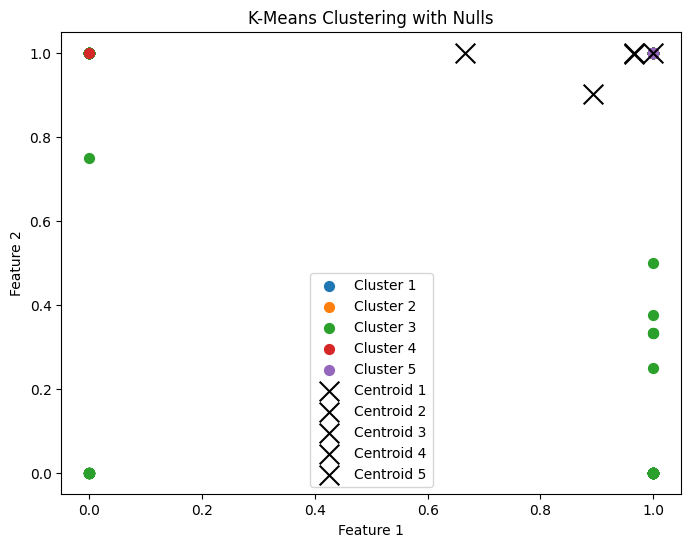

In [21]:
# Display the centroids and predictions
centroids_with_nulls = kmeans_with_nulls.centroids
predictions_with_nulls = kmeans_with_nulls.predict(data_clustering)

# Output the centroids and predictions
print("Centroids:\n", centroids_with_nulls)
#print("\nFirst 10 Predictions:\n", predictions_with_nulls[:10])

# Plotting the clusters with nulls
plt.figure(figsize=(8, 6))

# Plot each cluster with available data, ignoring NaNs
for i in range(kmeans_with_nulls.n_clusters):
    # Select data points without NaNs that are assigned to the current cluster
    cluster_data = data_clustering[~np.isnan(data_clustering).any(axis=1) & (predictions_with_nulls == i)]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}', s=50)

# Plot the centroids, excluding NaNs for plotting purposes
for idx, centroid in enumerate(centroids_with_nulls):
    if not np.isnan(centroid).any():
        plt.scatter(centroid[0], centroid[1], c='black', s=200, marker='x', label=f'Centroid {idx+1}')

plt.title('K-Means Clustering with Nulls')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


Let's now deep dive into the classical KMeans where we will be imputing the missing values. Financial missing values have been imputed previously. We just need to impute the ratings. We will proceed with the median.

Imputing missing values:

In [22]:
missing_values = df_clustering.isnull().sum()
missing_values[missing_values!=0] 

Rating_mean    291
dtype: int64

In [23]:
df_clustering_filled = df_clustering.copy()
df_clustering_filled['Rating_mean'] = df_clustering_filled['Rating_mean'].fillna(df_clustering['Rating_mean'].median())

We apply the elbow method to determine the optimal number of clusters for the KMeans approach.

In [25]:
from yellowbrick.cluster import KElbowVisualizer

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

c:\Users\gascm\OneDrive\Documents\HEC\DSB_2\Natixis\.natixis\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gascm\OneDrive\Documents\HEC\DSB_2\Natixis\.natixis\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gascm\OneDrive\Documents\HEC\DSB_2\Natixis\.natixis\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gascm\OneDrive\Documents\HEC\DSB_2\Natixis\.natixis\Lib\si

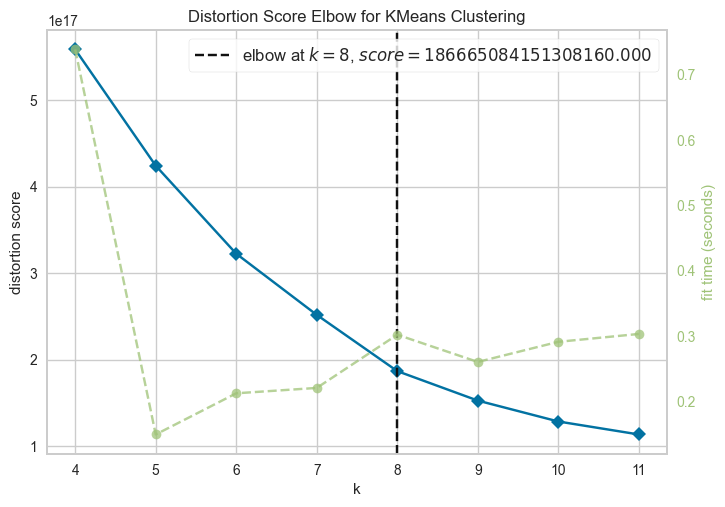

In [27]:
visualizer.fit(df_clustering_filled)        # Fit the data to the visualizer
visualizer.show();                          # Finalize and render the figure

Optimal number of cluster is 8.
<br>
Now let's move on to exploring the results we obtain.

In [28]:
model = KMeans(n_clusters=8, verbose=0, random_state=42)

In [29]:
clusters = model.fit_predict(df_clustering_filled)

c:\Users\gascm\OneDrive\Documents\HEC\DSB_2\Natixis\.natixis\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Explainability options:
- ExKMC
- Build a classification model for each label and look at Shap values